# IA006 - EFC01
# UNICAMP

## 229990 - Vítor Yudi Shinohara
## Tópico: Regressão Linear


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def generate_phi(data, K):
    phi = []
    for i in range(len(data) - K):
        phi_x = np.insert(np.flip(data[i:i + K]), 0, 1)
        phi.append(phi_x)
    return np.array(phi)

def generate_y(data, K):
    y = []
    for i in range(K, len(data)):
        y.append(data[i])
    return y

In [3]:
def predict_x_next(train_subset, test_subset, w, X, K):
    predicted_values = []
    
    for i in range(X):
        features = np.insert(np.flip(train_subset[i:]), 0, 1).T
        predicted_value = np.dot(features, w)

        train_subset = np.append(train_subset, test_subset[i])
        predicted_values.append(predicted_value)
        
    return predicted_values

In [4]:
def k_fold(x, y, k):
    
    if len(x) != len(y):
        print('X and Y must have the same shape.')
        print('X have shape of {} and Y have shape {}'.format(x.shape, y.shape))
        return None
    
    elements_per_fold = len(x) / k
    
    x_folds, y_folds = [], []
    for i in range(k):
        x_fold = x[i * elements_per_fold: (i+1) * elements_per_fold]
        y_fold = y[i * elements_per_fold: (i+1) * elements_per_fold]
        x_folds.append(x_fold)
        y_folds.append(y_fold)
    
    return x_folds, y_folds

In [5]:
def compute_error_k_fold(x, y, alpha):
    rmse = lambda predictions, sunspots_values_test: np.sqrt(np.sum(predictions - sunspots_values_test)**2) * 1/len(predictions)
    error_hist = []
    folds_number = len(x)
    
    for validation_index in range(folds_number):
        
        x_train, y_train, x_validation, y_validation = [], [], [], []
        
        for train_index in range(folds_number):
            
            if validation_index == train_index:
                x_validation = x[validation_index]
                y_validation = y[validation_index]
                continue
            
            try:
                x_train = np.append(x_train, x[train_index], axis=0)
            except:
                x_train = np.array(x[train_index])
            
            y_train += y[train_index]
        
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        identity = np.identity(x_train.shape[1])
        identity[0][0] = 0
        
        w = np.dot(np.dot(np.linalg.inv(np.dot(x_train.T, x_train) + alpha * identity), x_train.T), y_train)
        
        predictions = np.dot(x_validation, w)
        
        error = rmse(predictions, y_validation)
        error_hist.append(error)
    
    return np.mean(error_hist)
        

In [6]:
def remove_features(x, idx):
    if idx == 0:
        print("You can't remove the bias from Phi")
        return None
    phi_without_idx = []

    for phi in x:
        phi_without_idx.append(np.delete(phi, idx))
    
    return phi_without_idx
        

In [7]:
df = pd.read_csv('../data/sunspot.txt', delimiter=r"\s+", names=['Year','Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
df.head()

,Year,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1749,58.0,62.6,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5,158.6,85.2
1,1750,73.3,75.9,89.2,88.3,90.0,100.0,85.4,103.0,91.2,65.7,63.3,75.4
2,1751,70.0,43.5,45.3,56.4,60.7,50.7,66.3,59.8,23.5,23.2,28.5,44.0
3,1752,35.0,50.0,71.0,59.3,59.7,39.6,78.4,29.3,27.1,46.6,37.6,40.0
4,1753,44.0,32.0,45.7,38.0,36.0,31.7,22.0,39.0,28.0,25.0,20.0,6.7


In [8]:
matrix = df.values
_df_matrix = []
for row in matrix:
    for i in range(1,13):
        entry = [int(row[0]), row[i]]
        _df_matrix.append(entry)

_df_matrix = np.array(_df_matrix)

_df = pd.DataFrame(_df_matrix)

_df.columns = ['year', 'value']


In [9]:
# Test set: 5 recent years [2010 ~ 2014]
# 5 * 12 = 60
# Last 60 rows

years_test = _df_matrix[-60:,0]
sunspots_values_test = _df_matrix[-60:,1]

years_train = _df_matrix[:-60,0]
sunspots_values_train = _df_matrix[:-60,1]

In [10]:
months = ['Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years_with_months_train = []
for year in np.unique(years_train):
    for month in months:
        years_with_months_train.append('{}/{}'.format(year, month))
        
years_with_months_test = []
for year in np.unique(years_test):
    for month in months:
        years_with_months_test.append('{}/{}'.format(year, month))
        


In [11]:
phi = generate_phi(_df.values[:-60,1], 20)

y = generate_y(_df.values[:-60,1], 20)

w = np.dot(np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T), y)


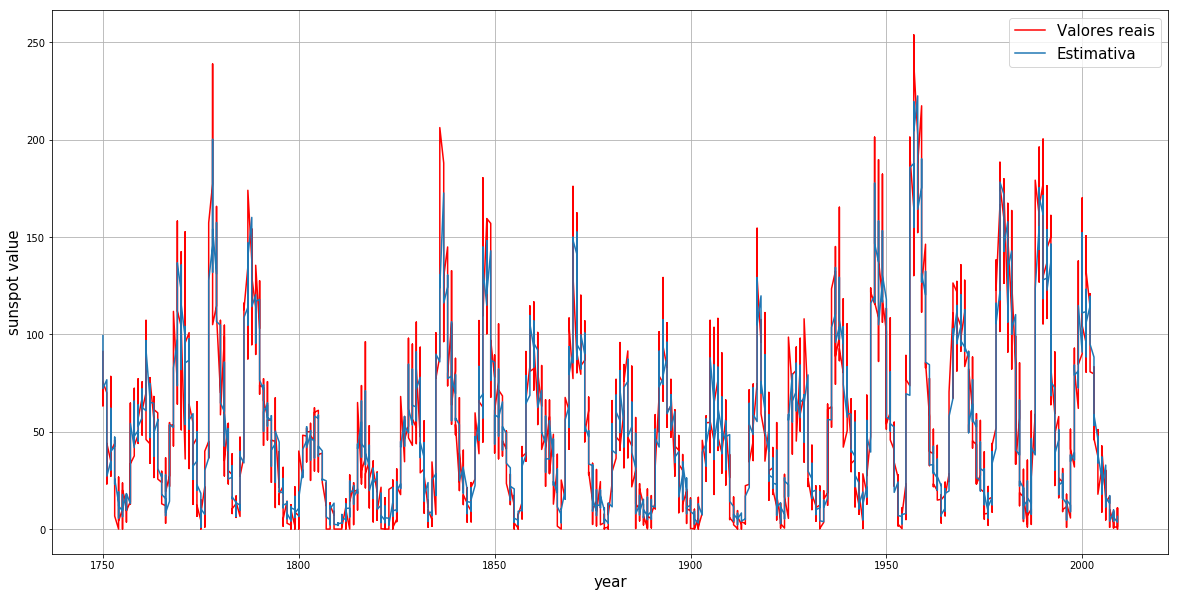

In [12]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(years_train[20:], sunspots_values_train[20:], 'r', label="Valores reais")
plt.plot(years_train[20:], np.dot(phi,w), label="Estimativa")
plt.legend(fontsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('sunspot value', fontsize=15)
plt.show()

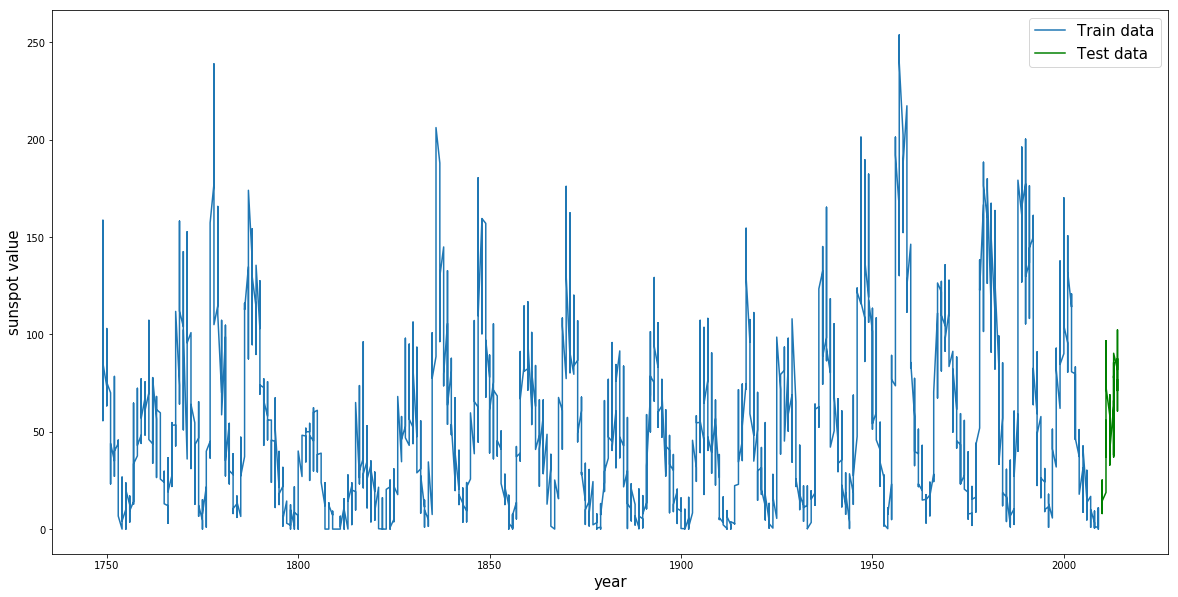

In [13]:
teste = years_with_months_train + years_with_months_train
plt.figure(figsize=(20,10))
plt.plot(years_train, sunspots_values_train, label='Train data')
plt.plot(years_test, sunspots_values_test, 'g', label='Test data')
plt.xlabel('year', fontsize=15)
plt.legend(fontsize=15)
plt.ylabel('sunspot value', fontsize=15)
plt.show()

In [14]:
last_train_subset = sunspots_values_train[-20:]

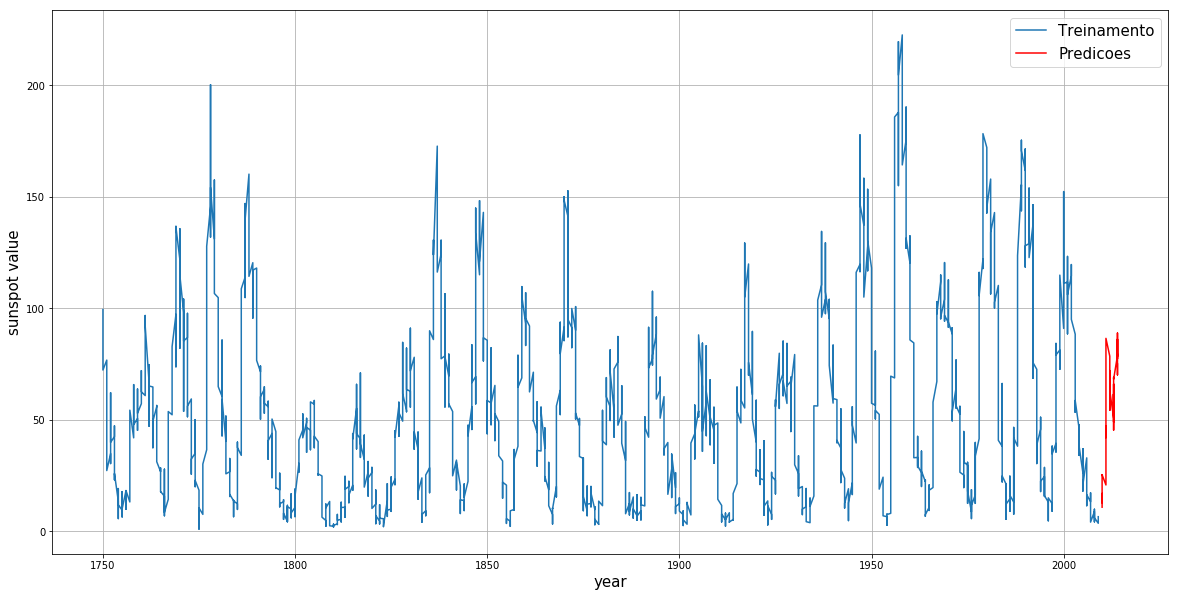

In [15]:
predictions = predict_x_next(last_train_subset, sunspots_values_test, w, 60, 20)
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(years_train[20:], np.dot(phi,w), label='Treinamento' )
plt.plot(years_test, predictions, 'r', label='Predicoes' )
plt.xlabel('year', fontsize=15)
plt.ylabel('sunspot value', fontsize=15)
plt.legend(fontsize=15)

plt.show()

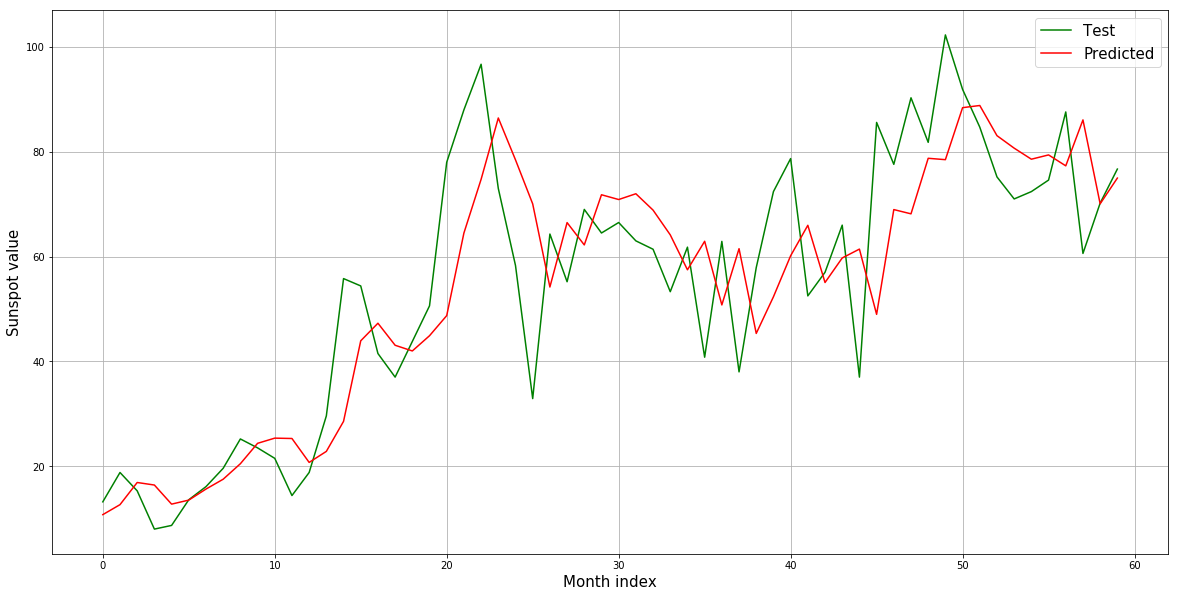

In [24]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(range(60), sunspots_values_test, 'g', label='Test')
plt.plot(range(60), predictions, 'r', label='Predicted')
plt.legend(fontsize=15)
plt.ylabel('Sunspot value', fontsize=15)
plt.xlabel('Month index', fontsize=15)
plt.show()
#sunspots_values_test


In [17]:
rmse = lambda predictions, sunspots_values_test: np.sqrt(np.sum(predictions - sunspots_values_test)**2) * 1/len(predictions)

rmse(predictions, sunspots_values_test)

0.6511413263871131

## K-Fold

In [18]:
x_fold, y_fold = k_fold(phi, y, 10)

## Wrapper - Backward elimination + Normalization

In [19]:
alphas = [ 10 ** i for i in range(-6, 3)]
alphas.append(0)
alphas

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 0]

In [20]:
indexes_remaining = range(0, 21)
errors_all_features = [ compute_error_k_fold(x_fold, y_fold, alpha) for alpha in alphas]
avg_error_all_features = np.min(errors_all_features)
alpha_min_error_for_all_features = [alphas[np.argmin(errors_all_features)]]

In [21]:
print("Error with all features: {}".format(avg_error_all_features))
print('==='*25)

number_total_features = 21

phi_iter = phi
last_error = avg_error_all_features

error_history = [avg_error_all_features]

while number_total_features > 1:
    
    min_error_for_all_features = []

    for i in range(1, number_total_features):
        # Remove a feature i
        phi_updated = remove_features(phi_iter, i)
        # Cria os folds
        x_fold, y_fold = k_fold(phi_updated, y, 10)
        # Cada posição = média do erro para o parâmetro alpha
        alpha_errors = [ compute_error_k_fold(x_fold, y_fold, alpha) for alpha in alphas]
        # Obtem o erro mínimo para todos os valores de Alpha e para a feature I removida
        min_error = np.min(alpha_errors)
        # Obtem o alpha utilizado para obter o menor erro
        alpha_min_error = alphas[np.argmin(alpha_errors)]
        # Adiciona em um vetor de erros mínimos para todas as features
        min_error_for_all_features.append(min_error)
        # Adiciona o alpha utilizado para obter o menor erro
        alpha_min_error_for_all_features.append(alpha_min_error)
    
    # Pega o índice do mínimo erro de todas as features eliminadas
    index_to_remove = np.argmin(min_error_for_all_features)
    # Deleta a feature do vetor phi
    phi_iter = remove_features(phi_iter, index_to_remove + 1)
    number_total_features -= 1
    
    indexes_remaining = np.delete(indexes_remaining, index_to_remove + 1)
    print('Index #{} was removed.\t\tMin error: {}\tAlpha: {}\tLen: {}'.format(index_to_remove + 1, min_error_for_all_features[index_to_remove] , alpha_min_error_for_all_features[index_to_remove], number_total_features))
    print('Features: {}'.format(indexes_remaining))
    error_history.append(min_error_for_all_features[index_to_remove])
    


Error with all features: 0.990663528474
Index #20 was removed.		Min error: 0.939427096998	Alpha: 0	Len: 20
Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Index #19 was removed.		Min error: 0.906470497224	Alpha: 0	Len: 19
Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Index #18 was removed.		Min error: 0.827670956265	Alpha: 0	Len: 18
Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Index #17 was removed.		Min error: 0.780657950422	Alpha: 0	Len: 17
Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Index #16 was removed.		Min error: 0.712162218415	Alpha: 0	Len: 16
Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Index #15 was removed.		Min error: 0.666273772902	Alpha: 0	Len: 15
Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Index #14 was removed.		Min error: 0.641535366813	Alpha: 0	Len: 14
Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Index #13 was removed.		Min error: 0.609923602621	

O índice 0 se diz respeito ao bias.

Quando em Phi, somente resta o bias, o erro é enorme.

Através da saída anterior, é possível notar que o melhor conjunto de características é:

[ 0  1  2  3  4  5  7  9 10]

Apresentando um erro de 0.590835126024

Onde 1 representa o atraso de 1 mês anterior, 2 o atraso de 2 meses anteriores e assim respectivamente.

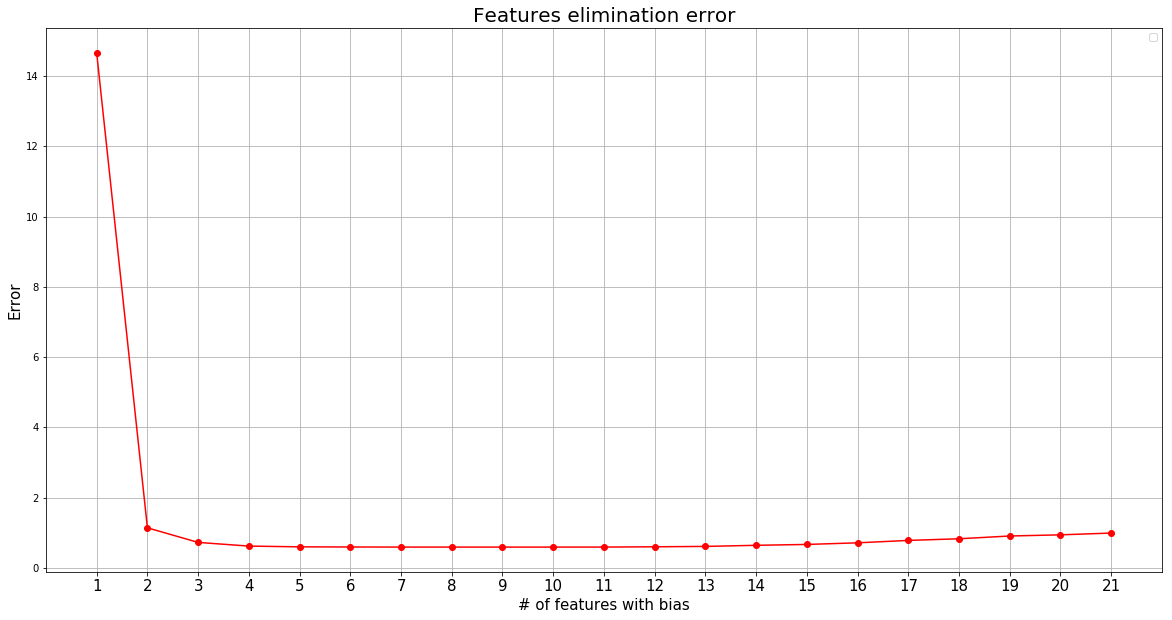

In [22]:
index = np.arange(21,0,-1)
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(index, error_history, marker='o', color='r') 
plt.xlabel('# of features with bias', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Features elimination error', fontsize=20)
plt.xticks(index, index, fontsize=15)
plt.legend()
plt.show()

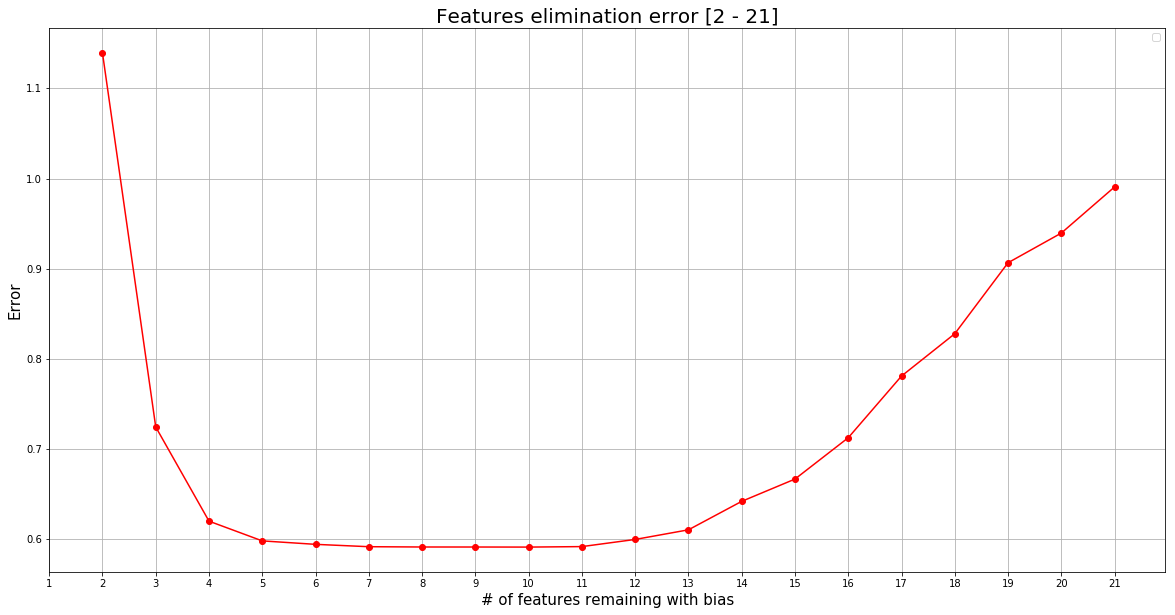

In [23]:
index = np.arange(21,0,-1)
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(index[:-1], error_history[:-1], marker='o', color='r') 
plt.xlabel('# of features remaining with bias', fontsize=15)
plt.ylabel('Error', fontsize=15) 
plt.title('Features elimination error [2 - 21]', fontsize=20)
plt.xticks(index, index)
plt.legend() 
plt.show()